In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

dataset = 2

if dataset == 1:
    expr = pd.read_csv('CAFs.txt', sep='\t')
    X_train = expr.values[:,0:(expr.shape[1]-1)]
    X_train = np.log(X_train + 1)
    n = X_train.shape[0]
    print("\nThis data set contains " + str(n) + " samples")
    y_train = np.array(expr.values[:,expr.shape[1]-1],dtype=np.int)
    print("\nDimensions of the  data set: ")
    print(X_train.shape, y_train.shape)

elif dataset == 2:
    import mnist_reader

    X_train, y_train = mnist_reader.load_mnist('data/mnist', kind='train')
    X_test, y_test = mnist_reader.load_mnist('data/mnist', kind='t10k')
    
    n = 2000
    #np.random.seed(6333)
    #ids = np.random.choice(range(60000),n)
    #X_train, y_train = X_train[ids], y_train[ids]
    
    n = X_train.shape[0]
    
    
    X_train = X_train.astype(np.double)
    X_train = X_train/(np.max(X_train))
    print(X_train.dtype)
    
    classes = [
        '0',
        '1',
        '2',
        '3',
        '4',
        '5',
        '6',
        '7',
        '8',
        '9']
    
    print(y_train)
    print(X_train.shape, y_train.shape)
    
    
elif dataset == 3:
    import mnist_reader 
    
    X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
    X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
    
    n = 2000
    np.random.seed(6333)
    ids = np.random.choice(range(60000),n)
    X_train, y_train = X_train[ids], y_train[ids]
    
    n = X_train.shape[0]
    
    X_train = X_train.astype(np.double)
    X_train = X_train/(np.max(X_train))
    
    classes = [
        'T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot']
    
    print(X_train.shape, y_train.shape, X_train.dtype)
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

float64
[5 0 4 ... 5 6 8]
(60000, 784) (60000,)


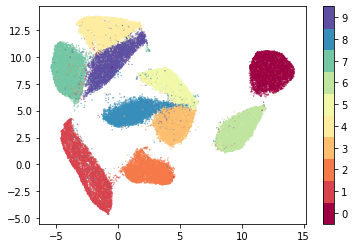

In [2]:
import umap

ump = umap.UMAP(n_neighbors=30,
        min_dist=0.25,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)


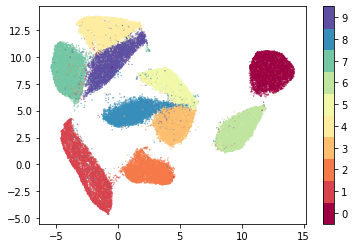

In [3]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [4]:
n_neighbors=30

#sort_idx = np.argsort(dist,axis=1)

with open('sorted_index.npy', 'rb') as f:
    sort_idx = np.load(f)

sort_idx = sort_idx[:,1:n_neighbors+1]
print(sort_idx.shape, sort_idx[:,1].shape)

#rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
#print(rho[0:4])

#rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
#rho = np.array(rho)
with open('rho_mnist.npy', 'rb') as f:
    rho = np.load(f)

print(rho[0:4])
print(rho.shape)

(60000, 30) (60000,)
[6.12342111 4.0025386  5.40247284 1.64542403]
(60000,)


In [ ]:
import gc

print(gc.collect())

In [ ]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

#sigma, weights = search_sigma(dists = dist[0,sort_idx[0,:]],rho = rho[0],k = n_neighbors)

#print(np.sum(np.exp( -(dist[0,1:] - rho[0]) / sigma ) ))

#print(dist[0,:] - rho[0], dist[0,0], rho[0])

#print(sigma)

In [ ]:
sigmas = []

directed_graph = []
'''
for i in range(n):
    if (i+1)%1000 == 0:
        print('Processed ', i+1, ' of ', n, ' samples.')
    sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)
    
    probs = np.zeros(n)
    probs[sort_idx[i,:]] = weights
    #print(sum(weights), np.log2(n_neighbors))
    #print(sort_idx[i,:])
    #print(probs[1770:1780])
    
    directed_graph.append(probs)

prob = np.array(directed_graph)
#'''  

#with open('probs_n_neighbor30.npy', 'rb') as f:
#    prob = np.load(f)
    

#print(prob.shape)


#print(prob[0:10,0:10])

In [6]:
import gc
gc.collect()

#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
#P = (prob + np.transpose(prob)) / 2

with open('undirected_graph.npy', 'rb') as f:
    P = np.load(f)
 

'''
P = np.zeros((n,n))

for i in range(n):
    if i%1000 == 0:
        print('Completed ', i, ' of ', n)
    for j in range(i,n):
        p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i]
        P[i,j] = p
        P[j,i] = p
#'''
print(np.sum(P[0,:]==0))


#with open('undirected_graph.npy', 'wb') as f:
#    np.save(f, P)
    
#with open('undirected_graph.npy', 'rb') as f:
#    P = np.load(f)

print(P.shape)

59969
(60000, 60000)


Hyperparameters a = 1.121436342369708 and b = 1.057499876613678


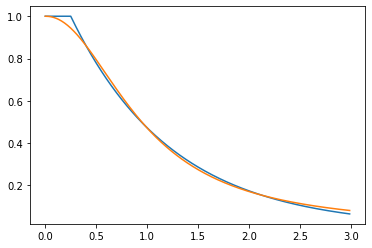

In [7]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [8]:
import torch
from network_sig import network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = network(channels=[X_train.shape[1],500,300,200,100,100,100,2]).to(device)

criterion_mse = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))


In [9]:
Y = []
X_train32 = X_train.astype(np.float32)

print('Conversion Done')
X_torch = torch.as_tensor(X_train32, dtype=torch.float32).to(device)
Y_umap = torch.as_tensor(y_umap, dtype=torch.float32).to(device)
print('Tensor Build Done')


Conversion Done
Tensor Build Done


completed  0  of  60000
completed  10000  of  60000
completed  20000  of  60000
completed  30000  of  60000
completed  40000  of  60000
completed  50000  of  60000
(60000, 2)


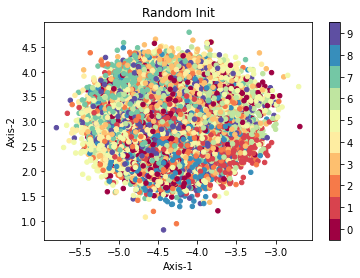

In [10]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y.shape)


plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 20)
plt.title("Random Init")
plt.xlabel("Axis-1") #, fontsize = 20); 
plt.ylabel("Axis-2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()

In [11]:
def criterion_pos_old(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2, dim = 0) ** b
    y = torch.log(factor)
    
    return y

def criterion_neg_old(x,y,a,b):
    factor = a * torch.sum((x-y)**2) ** b
    y = - torch.log(0.0001+factor) + torch.log(1 + factor)
    
    return y

def phi(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2, dim=1) ** b
    y = 1/factor
    
    return y

def criterion_pos(x,y,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(prob)
    
    return torch.sum(y)

def criterion_neg(x,y,p,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(1-prob+0.000001)*(1-p)
    
    return torch.sum(y)
    

Y = model(X_torch[0:10,:])
Z = criterion_pos(Y[0:4,:],Y[4:8,:],1.0,1.0)
print(Y.size(), Z.size(), Z.item())

torch.Size([10, 2]) torch.Size([]) 0.3651970624923706


In [12]:
#from sklearn.manifold import SpectralEmbedding


#LEARNING_RATE = 1
epochs = 20

#xpp = xpp
#print(k)

batch_size = 60

CE_array = []
print("Running Gradient Descent: \n")
for epoch in range(epochs):
    
    for idx in range(3,n):
        choices_0 = np.random.choice(n, batch_size)
        k_ch = np.random.randint(low = 0, high = n_neighbors, size=batch_size)
        choices_1 = sort_idx[choices_0,k_ch]
        
        #print(choices_0.shape,choices_1.shape)
        
        optimizer.zero_grad()
        
        loss = 0
        
        Y0 = model(X_torch[choices_0,:])
        Y1 = model(X_torch[choices_1,:])
        
        cr = criterion_pos(Y0, Y1, a, b) + criterion_mse(Y0,Y_umap[choices_0,:]) + criterion_mse(Y1, Y_umap[choices_1,:])
        loss = loss + cr
        #print(cr)
        if np.isnan(cr.detach().cpu().item()):
            print(epoch,idx,cr)
            break
        
        #gr_1 = get_grad_logphi(y[i,:], y[ij,:],a,b)
        #y[i,:] = y[i,:] + LEARNING_RATE * gr_1
        
        for j in range(5):
            k_ch = np.random.randint(low = 0, high = n, size=batch_size)
            #Y0 = model(X_torch[i:i+1,:])
            Y1 = model(X_torch[k_ch,:])
            Prob_sample = torch.as_tensor(P[choices_1,k_ch].reshape(-1), dtype=torch.float32).to(device)
            
            cr = criterion_neg(Y0, Y1, Prob_sample, a, b) + criterion_mse(Y1, Y_umap[k_ch,:])
            loss = loss + cr
            #print('inside loop: ', cr)
            if np.isnan(cr.detach().cpu().item()):
                print('inside loop: ', epoch, idx, j, cr)
                break
            
            
        loss.backward()
        optimizer.step()
        
                
    #LEARNING_RATE = 1.0 - epoch / epochs
    if (epoch+1)%1 == 0:
        print('Completed ', epoch , ' of ', epochs)
        torch.save(model.state_dict(), 'nets_MSE_CE_UMAP/epoch'+str(epoch)+'.pth')


Running Gradient Descent: 

Completed  0  of  20
Completed  1  of  20
Completed  2  of  20
Completed  3  of  20
Completed  4  of  20
Completed  5  of  20
Completed  6  of  20
Completed  7  of  20
Completed  8  of  20
Completed  9  of  20
Completed  10  of  20
Completed  11  of  20
Completed  12  of  20
Completed  13  of  20
Completed  14  of  20
Completed  15  of  20
Completed  16  of  20
Completed  17  of  20
Completed  18  of  20
Completed  19  of  20


In [ ]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%100 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y)

plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 20)
plt.title("UMAP")
plt.xlabel("UMAP 1") #, fontsize = 20); 
plt.ylabel("UMAP 2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()